<a href="https://colab.research.google.com/github/Mena-SA-Kamel/cell-features/blob/feature%2Fvae/VAE_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using Variational Autoencoder to Extract Feature Embeddings from MNIST

In [1]:
# Python helpers
import os
import numpy as np

# Torch model imports
import torch
import torch.nn as nn

# Torch dataset imports
from torchvision.datasets import MNIST

# Torch data loader + transforms
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

# Plotting functions
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import save_image, make_grid

Creating Transforms

In [2]:
# # Creating an iterator for the training data
# num_samples = 25
# dataiter = iter(train_loader)
# images, labels = next(dataiter)
# sample_images = [images[i,0] for i in range(num_samples)]

# fig = plt.figure(figsize=(5, 5))
# grid = ImageGrid(fig, 111, nrows_ncols=(5, 5), axes_pad=0.1)

# for ax, im in zip(grid, sample_images):
#     ax.imshow(im, cmap='gray')
#     ax.axis('off')

# plt.show()

Defining the VAE class

In [3]:
transform = transforms.Compose([transforms.ToTensor()])
# download the MNIST datasets
path = '/content/datasets'
if not os.path.exists(path):
  os.makedirs(path, exist_ok=True)

train_dataset = MNIST(path, transform=transform, download=True)
test_dataset  = MNIST(path, transform=transform, download=True)

batch_size = 100
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

print(device)
# New VAE Class
class VariationalEncoder(nn.Module):
  def __init__(self, input_dim, hidden_dim, latent_dim):
    super(VariationalEncoder, self).__init__()
    # TODO: Change linear layers to Conv layers
    self.hidden_layer_1 = nn.Linear(input_dim, hidden_dim)
    self.hidden_layer_2 = nn.Linear(hidden_dim, hidden_dim)
    self.mean_layer = nn.Linear(hidden_dim, latent_dim)
    self.logvar_layer = nn.Linear(hidden_dim, latent_dim)
    self.N = torch.distributions.Normal(0, 1) # Gaussian normalization
    self.N.loc = self.N.loc.cuda() # Moving the loc/ mean of the distribution to CUDA
    self.N.scale = self.N.scale.cuda() # Moving the scale/ std of the distribution to CUDA
    self.KL = 0

  def forward(self, x):
    x = torch.flatten(x, start_dim=1) # Flatten the image
    x = nn.functional.leaky_relu(self.hidden_layer_1(x), 0.2)
    x = nn.functional.leaky_relu(self.hidden_layer_2(x), 0.2)
    means = self.mean_layer(x)
    log_vars = torch.exp(self.logvar_layer(x)) # eNetwork predicting log(sigma **2) = log(var)
    # latent distribution using reparameterization trick to enable backpropagation
    var = torch.exp(0.5*log_vars) # torch.exp(0.5*log_vars) -> sqrt(var) = sigma
    epsilon = torch.randn_like(var).to(device)
    z = means + (epsilon * var)
    # KL divergence
    self.KL = (-0.5*(1 + log_vars - means**2 - torch.exp(log_vars))).sum() # torch.exp(log_vars)) -> var = sigma **2
    return z

class Decoder(nn.Module):
  def __init__(self, latent_dim, hidden_dim, output_dim):
    super(Decoder, self).__init__()
    self.hidden_layer_1 = nn.Linear(latent_dim, hidden_dim)
    self.hidden_layer_2 = nn.Linear(hidden_dim, hidden_dim)
    self.output_layer = nn.Linear(hidden_dim, output_dim)

  def forward(self, z):
    z = nn.functional.leaky_relu(self.hidden_layer_1(z), 0.2)
    z = nn.functional.leaky_relu(self.hidden_layer_2(z), 0.2)
    z = torch.sigmoid(self.output_layer(z)) # So it outputs a numpber between 0-1
    return z.reshape((-1, 1, 28, 28))


class VariationalAutoEncoder(nn.Module):
  def __init__(self, input_dim, hidden_dim, latent_dim):
    super(VariationalAutoEncoder, self).__init__()
    self.encoder = VariationalEncoder(input_dim, hidden_dim, latent_dim)
    self.decoder = Decoder(latent_dim, hidden_dim, input_dim)

  def forward(self, x):
    z = self.encoder(x)
    x_hat = self.decoder(z)
    return x_hat

cuda


In [4]:
def train(vae, data, epochs=20):
  optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)
  for epoch in range(epochs):
    overall_loss = 0
    for batch_id, (x, _) in enumerate(data):
      x = x.to(device)
      optimizer.zero_grad()
      x_hat = vae.forward(x)
      # reconstruction_loss = ((x - x_hat)**2).sum()
      reconstruction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
      loss = reconstruction_loss + vae.encoder.KL
      loss.backward()
      optimizer.step()
      overall_loss += loss.item()
    if batch_id > 0:
      print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss / (batch_id*batch_size), "Reconstruction loss: ", reconstruction_loss.item(), "KL: ", vae.encoder.KL.item())
  return vae

vae = VariationalAutoEncoder(input_dim=784, hidden_dim=100, latent_dim=2).to(device)
vae = train(vae, train_loader, epochs=30)

	Epoch 1 	Average Loss:  204.52451295779423 Reconstruction loss:  17832.861328125 KL:  675.8216552734375
	Epoch 2 	Average Loss:  181.44023597271493 Reconstruction loss:  17897.1328125 KL:  621.22509765625
	Epoch 3 	Average Loss:  178.916421509808 Reconstruction loss:  16577.244140625 KL:  878.2794189453125
	Epoch 4 	Average Loss:  177.97950819725585 Reconstruction loss:  17025.02734375 KL:  763.89892578125
	Epoch 5 	Average Loss:  177.09695480423102 Reconstruction loss:  17480.927734375 KL:  693.816162109375
	Epoch 6 	Average Loss:  176.6116567162719 Reconstruction loss:  16558.87890625 KL:  867.126953125
	Epoch 7 	Average Loss:  176.1941649167884 Reconstruction loss:  16951.091796875 KL:  1011.36376953125
	Epoch 8 	Average Loss:  175.78903286075752 Reconstruction loss:  16460.099609375 KL:  940.6197509765625
	Epoch 9 	Average Loss:  175.48003783975898 Reconstruction loss:  17237.45703125 KL:  918.5283203125
	Epoch 10 	Average Loss:  175.2300429915745 Reconstruction loss:  16456.36718

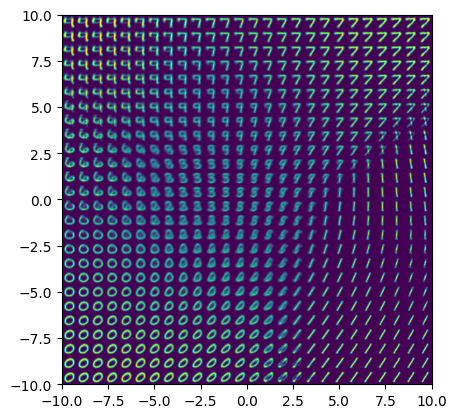

In [12]:
def plot_reconstructed(autoencoder, r0=(-10, 10), r1=(-10, 10), n=26):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = autoencoder.decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])
plot_reconstructed(vae)


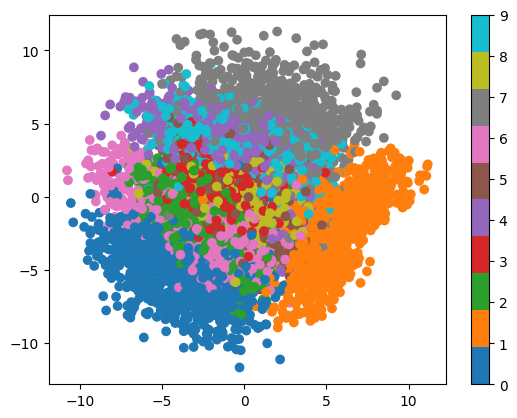

In [13]:
def plot_latent(autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break
plot_latent(vae, train_loader)

In [7]:
# class VAE(nn.Module):
#   def __init__(self, input_dim=784, hidden_dim=400, latent_dim=200, device=device):
#     super(VAE, self).__init__()

#     #Encoder
#     self.encoder = nn.Sequential(
#         nn.Linear(input_dim, hidden_dim),
#         nn.LeakyReLU(0.2),
#         nn.Linear(hidden_dim, latent_dim),
#         nn.LeakyReLU(0.2)
#     )

#     # Latent mean and variance
#     self.mean_layer = nn.Linear(latent_dim, 1)
#     self.logvar_layer = nn.Linear(latent_dim, 1)

#     # Decoder
#     self.decoder = nn.Sequential(
#         nn.Linear(1, latent_dim),
#         nn.LeakyReLU(0.2),
#         nn.Linear(latent_dim, hidden_dim),
#         nn.LeakyReLU(0.2),
#         nn.Linear(hidden_dim, input_dim),
#         nn.Sigmoid()
#     )

#   def encode(self, x):
#     x = self.encoder(x)
#     mean, logvar = self.mean_layer(x), self.logvar_layer(x)
#     return mean, logvar

#   def reparametrization(self, mean, var):
#     epsilon = torch.randn_like(var).to(device)
#     z = mean + var*epsilon
#     return z

#   def decode(self, x):
#     return self.decoder(x)

#   def forward(self, x):
#     mean, logvar = self.encode(x)
#     z = self.reparametrization(mean, logvar)
#     x_hat = self.decode(z)
#     return x_hat, mean, logvar




In [8]:
# def loss_function(x, x_hat, mean, log_var):
#     reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
#     KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
#     return reproduction_loss + KLD

# def train(model, optimizer, epochs, device, train_loader, x_dim=784):
#     model.train()
#     for epoch in range(epochs):
#       overall_loss = 0
#       for batch_idx, (x,_) in enumerate(train_loader):
#         x = x.view(batch_size, x_dim).to(device)
#         optimizer.zero_grad()
#         x_hat, mean, log_var = model(x)
#         loss = loss_function(x, x_hat,mean, log_var)
#         overall_loss += loss.item()
#         loss.backward()
#         optimizer.step()
#       print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss/(batch_idx*batch_size))
#     return overall_loss

In [ ]:
# # %env CUDA_LAUNCH_BLOCKING=1
# # os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
# print (device)
# model = VAE().to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# train(model, optimizer, epochs=50, device=device, train_loader=train_loader)

In [ ]:
# def generate_digit(mean, var):
#     z_sample = torch.tensor([[mean]], dtype=torch.float).to(device)
#     x_decoded = model.decode(z_sample)
#     digit = x_decoded.detach().cpu().reshape(28, 28) # reshape vector to 2d array
#     plt.title(f'[{mean},{var}]')
#     plt.imshow(digit, cmap='gray')
#     plt.axis('off')
#     plt.show()